### Import Dependencies

In [1]:
import random
random.seed(0)

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

### Constant Variables

In [3]:
DATASET_PATH = './knee-osteoarthritis_2'

In [4]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


### Dataset 

In [6]:
from src.dataset.augmented_dataset import get_KneeOsteoarthritis_Edges, KneeOsteoarthritis_Edges

transform_toTensor = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val_dataset = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)
test_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform_toTensor)

dataset_all = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [0.7, 0.1, 0.2])
train_dataset = KneeOsteoarthritis_Edges(train_dataset)
val_dataset = KneeOsteoarthritis_Edges(val_dataset)
test_dataset = KneeOsteoarthritis_Edges(test_dataset)

In [7]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

4736 676 1353


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

In [9]:
row = train_dataset[1]
normal_ex = row[0]
augmented_ex = row[1]
print(normal_ex.shape, augmented_ex.shape)

torch.Size([3, 256, 256]) torch.Size([1, 224, 224])


### Data Loader

In [10]:
from torch.utils.data import DataLoader
from src.other import getWeightedDataLoader
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [11]:
class IntermediarySpaceModel(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        # Size of layer block
        S = 24
        
        # Images
        self.imagesClassifier = nn.Sequential(
            nn.Conv2d(3, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.2),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 7 * 7, S*2),
        )

        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(1, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 6 * 6, S*2),
        )
        
        self.outputCombiner = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*4, S*3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*3, S),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S, num_classes),
        )

    def forward(self, images: torch.Tensor, edges: torch.Tensor) -> torch.Tensor:
        
        # Images
        images = self.imagesClassifier(images)
        
        # Edges
        edges = self.edgesClassifier(edges)
        
        # Combining outputs
        concated = torch.cat((images, edges), 1)
        res = self.outputCombiner(concated)
        
        return res

In [12]:
# from src.models.custom import CustomModel

# model = EarlyIntermediarySpaceModel(3, 0)
model = IntermediarySpaceModel(4, 0.5)
model = model.to(device)

In [13]:
# print(sum(p.numel() for p in net.classifier.parameters()) ,sum(p.numel() for p in net.edgesClassifier.parameters()) )
print(sum(p.numel() for p in model.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(sum(p.numel() for p in trainable_parameters))

287044
287044


### Training Loop

#### Setting optimizer

In [14]:
import torch.optim as optim
from src.other import getClassesFrequency

class_weights = getClassesFrequency(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(class_weights, weights_tensor)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

{0: 2269, 2: 767, 1: 1524, 3: 176} tensor([2269.,  767., 1524.,  176.], device='cuda:0')


In [15]:
decayRate100 = 0.6
decayRate1 = decayRate100**(1/100)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate1)

print(decayRate1)

0.9949047687155309


In [16]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

#### Setting Logger

In [17]:
# EXP_NAME = "5/0"
# from torch.utils.tensorboard import SummaryWriter

# logger = SummaryWriter(log_dir=f"logs/experiments/{EXP_NAME}")

In [18]:
epochCounter = 0

#### Training Loop

In [19]:
from src.validation import validate

def train_many(model, epochs_nr, logger = None, lr_scheduler = None, regularization_type = "L2", lambda_reg=0.01):
    global epochCounter
    
    for epoch in range(0, epochs_nr):  # loop over the dataset multiple times
        epoch_correct = 0
        epoch_samples = 0
        epoch_batches = 0
        running_loss = 0.0
    
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            images, edges, labels = data
            images = images.to(device)
            edges = edges.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(images, edges)
            loss = criterion(outputs, labels)
            
            # Apply L1 regularization
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
                
            # Apply L2 regularization
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm
                
            loss.backward()
            
            optimizer.step()
            
            # Changing outputs (logits) to labels
            outputs_clear = outputs.max(1).indices
            
            epoch_correct += (outputs_clear == labels).float().sum()
            epoch_samples += len(outputs)
            epoch_batches +=1
            
            running_loss += loss.item()
        
        tAccuracy = epoch_correct / epoch_samples * 100
        tLoss = running_loss / epoch_batches
        
        # Validation
        vAccuracy, vLoss = validate(model, val_loader, criterion, device)
        
        if logger != None:

            logger.add_text("REGULARIZATION_TYPE", regularization_type, global_step=epochCounter)
            logger.add_scalar("REGULARIZATION_LAMBDA", lambda_reg, global_step=epochCounter)
            logger.add_scalar("learning_rate", get_lr(optimizer), global_step=epochCounter)
            
            logger.add_scalar("Accuracy/train", tAccuracy, global_step=epochCounter)
            logger.add_scalar("Loss/train", tLoss, global_step=epochCounter)
            logger.add_scalar("Accuracy/validation", vAccuracy, global_step=epochCounter)
            logger.add_scalar("Loss/validation", vLoss, global_step=epochCounter)
        
        print(f'Epoch {epochCounter}: Training: accuracy: {tAccuracy:.3f}%, loss: {tLoss:.3f}; Validation: accuracy: {vAccuracy:.3f}%, loss: {vLoss:.3f}')
        
        epochCounter += 1
        
        if lr_scheduler != None:
            lr_scheduler.step()
        
        # print("lr= " + str(get_lr(optimizer)))
    print('Finished Training')

#### Data Visualization

In [20]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [21]:
def visualize_cm(cm, true_labels, predicted_labels):
    cmplot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
    cmplot.plot(cmap = 'Blues')
    plt.show()
    
def visualize(model, loader):
    correct = 0
    total = 0
    model.eval()
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, edges, labels in tqdm(loader):
            inputs, edges, labels = inputs.to(device), edges.to(device), labels.to(device)
            outputs = model(inputs, edges)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

    print(classification_report(true_labels, predicted_labels, zero_division=np.nan))

    cm = confusion_matrix(true_labels, predicted_labels)
    visualize_cm(cm, true_labels, predicted_labels)

### Training Model

In [22]:
train_many(model, 100, None, my_lr_scheduler, "L2", 0.003)

Epoch 0: Training: accuracy: 37.458%, loss: 1.935; Validation: accuracy: 47.189%, loss: 1.034
Epoch 1: Training: accuracy: 44.764%, loss: 1.362; Validation: accuracy: 48.521%, loss: 0.954
Epoch 2: Training: accuracy: 46.178%, loss: 1.260; Validation: accuracy: 49.112%, loss: 0.897
Epoch 3: Training: accuracy: 46.685%, loss: 1.218; Validation: accuracy: 49.704%, loss: 0.956
Epoch 4: Training: accuracy: 47.192%, loss: 1.180; Validation: accuracy: 51.627%, loss: 0.896
Epoch 5: Training: accuracy: 47.741%, loss: 1.145; Validation: accuracy: 52.367%, loss: 0.843
Epoch 6: Training: accuracy: 47.340%, loss: 1.115; Validation: accuracy: 51.775%, loss: 0.815
Epoch 7: Training: accuracy: 47.635%, loss: 1.065; Validation: accuracy: 51.479%, loss: 0.850
Epoch 8: Training: accuracy: 47.846%, loss: 1.031; Validation: accuracy: 51.627%, loss: 0.809
Epoch 9: Training: accuracy: 47.889%, loss: 0.992; Validation: accuracy: 51.627%, loss: 0.717
Epoch 10: Training: accuracy: 47.931%, loss: 0.972; Validati

100%|██████████| 11/11 [00:00<00:00, 41.31it/s]


Test Accuracy: 70.66%
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       635
           1       0.66      0.45      0.54       432
           2       0.60      0.84      0.70       227
           3        nan      0.00      0.00        59

    accuracy                           0.71      1353
   macro avg       0.68      0.55      0.52      1353
weighted avg       0.70      0.71      0.68      1353



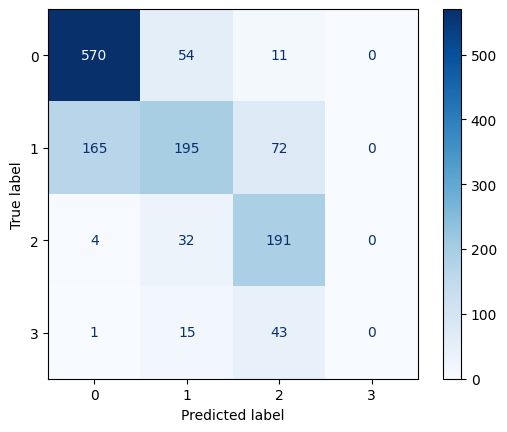

In [23]:
visualize(model, test_loader)

In [24]:
train_many(model, 100, None, my_lr_scheduler, "L2", 0.003)

Epoch 100: Training: accuracy: 92.103%, loss: 0.235; Validation: accuracy: 72.633%, loss: 0.889
Epoch 101: Training: accuracy: 94.447%, loss: 0.191; Validation: accuracy: 72.929%, loss: 0.974
Epoch 102: Training: accuracy: 95.334%, loss: 0.172; Validation: accuracy: 71.302%, loss: 1.402
Epoch 103: Training: accuracy: 95.650%, loss: 0.162; Validation: accuracy: 73.225%, loss: 1.176
Epoch 104: Training: accuracy: 95.988%, loss: 0.153; Validation: accuracy: 72.485%, loss: 1.260
Epoch 105: Training: accuracy: 96.157%, loss: 0.146; Validation: accuracy: 72.485%, loss: 1.280
Epoch 106: Training: accuracy: 96.178%, loss: 0.141; Validation: accuracy: 72.189%, loss: 1.301
Epoch 107: Training: accuracy: 96.178%, loss: 0.137; Validation: accuracy: 72.337%, loss: 1.349
Epoch 108: Training: accuracy: 96.242%, loss: 0.133; Validation: accuracy: 71.598%, loss: 1.538
Epoch 109: Training: accuracy: 96.242%, loss: 0.130; Validation: accuracy: 72.485%, loss: 1.367
Epoch 110: Training: accuracy: 96.263%, 

100%|██████████| 11/11 [00:00<00:00, 40.09it/s]


Test Accuracy: 69.48%
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       635
           1       0.56      0.63      0.59       432
           2       0.68      0.67      0.67       227
           3        nan      0.00      0.00        59

    accuracy                           0.69      1353
   macro avg       0.68      0.53      0.52      1353
weighted avg       0.70      0.69      0.68      1353



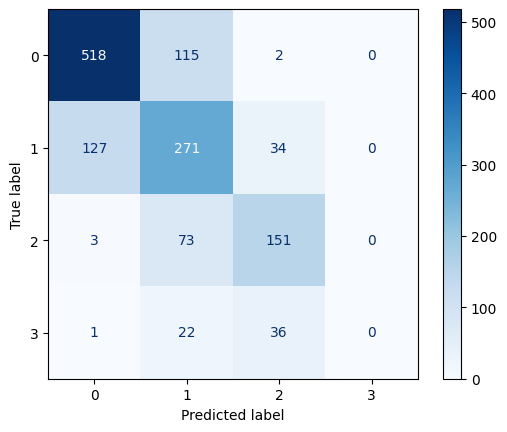

In [25]:
visualize(model, test_loader)

100%|██████████| 37/37 [00:00<00:00, 37.91it/s]

Test Accuracy: 96.01%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2269
           1       0.95      0.99      0.97      1524
           2       0.89      1.00      0.94       767
           3        nan      0.00      0.00       176

    accuracy                           0.96      4736
   macro avg       0.94      0.75      0.73      4736
weighted avg       0.96      0.96      0.94      4736



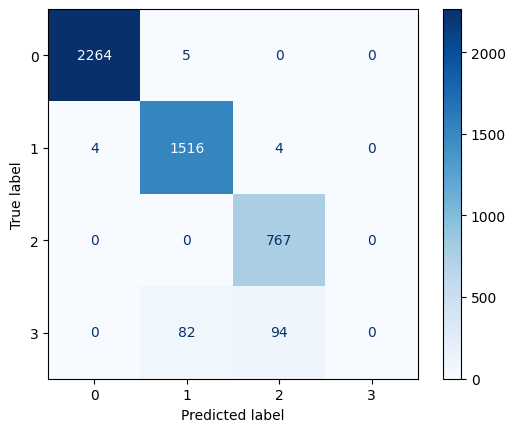

In [28]:
visualize(model, train_loader)

In [29]:
train_many(model, 10, None, my_lr_scheduler, "L2", 0.003)

Epoch 200: Training: accuracy: 96.030%, loss: 0.095; Validation: accuracy: 71.746%, loss: 1.184
Epoch 201: Training: accuracy: 96.263%, loss: 0.085; Validation: accuracy: 72.337%, loss: 1.193
Epoch 202: Training: accuracy: 96.537%, loss: 0.080; Validation: accuracy: 70.710%, loss: 1.316
Epoch 203: Training: accuracy: 97.825%, loss: 0.077; Validation: accuracy: 70.710%, loss: 1.488
Epoch 204: Training: accuracy: 98.501%, loss: 0.075; Validation: accuracy: 71.154%, loss: 1.521
Epoch 205: Training: accuracy: 99.198%, loss: 0.073; Validation: accuracy: 71.450%, loss: 1.510
Epoch 206: Training: accuracy: 99.430%, loss: 0.072; Validation: accuracy: 70.710%, loss: 1.604
Epoch 207: Training: accuracy: 99.704%, loss: 0.071; Validation: accuracy: 70.562%, loss: 1.648
Epoch 208: Training: accuracy: 99.831%, loss: 0.070; Validation: accuracy: 70.562%, loss: 1.490
Epoch 209: Training: accuracy: 99.873%, loss: 0.069; Validation: accuracy: 70.710%, loss: 1.563
Finished Training


100%|██████████| 37/37 [00:00<00:00, 38.55it/s]

Test Accuracy: 99.89%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2269
           1       1.00      1.00      1.00      1524
           2       0.99      1.00      1.00       767
           3       1.00      0.97      0.99       176

    accuracy                           1.00      4736
   macro avg       1.00      0.99      1.00      4736
weighted avg       1.00      1.00      1.00      4736



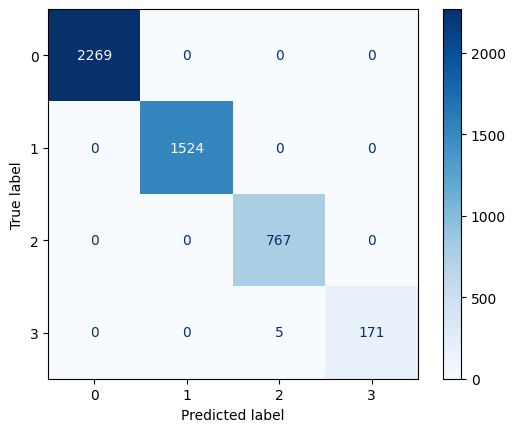

In [30]:
visualize(model, train_loader)

100%|██████████| 11/11 [00:00<00:00, 38.53it/s]


Test Accuracy: 69.55%
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       635
           1       0.59      0.57      0.58       432
           2       0.72      0.65      0.68       227
           3       0.19      0.17      0.18        59

    accuracy                           0.70      1353
   macro avg       0.57      0.56      0.57      1353
weighted avg       0.69      0.70      0.69      1353



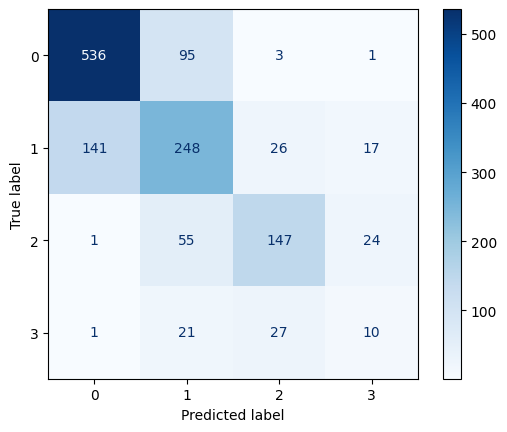

In [31]:
visualize(model, test_loader)

100%|██████████| 6/6 [00:00<00:00, 38.27it/s]


Test Accuracy: 70.71%
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       349
           1       0.61      0.59      0.60       219
           2       0.75      0.54      0.63        92
           3       0.13      0.25      0.17        16

    accuracy                           0.71       676
   macro avg       0.57      0.56      0.56       676
weighted avg       0.72      0.71      0.71       676



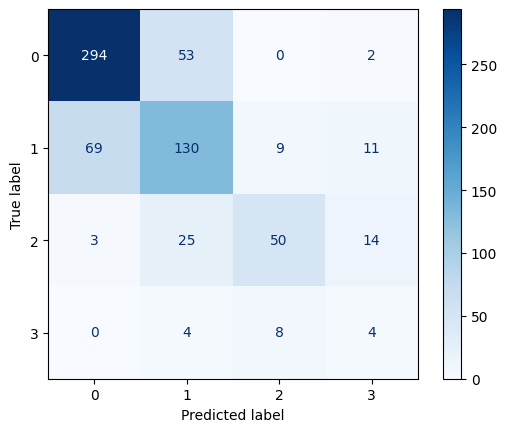

In [32]:
visualize(model, val_loader)